In [1]:
import os
import subprocess

import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm import tqdm
from bed_reader import open_bed
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set(style="whitegrid", context="notebook", palette="pastel")

import warnings
warnings.simplefilter('ignore')

1. [plink LD arguments](https://www.cog-genomics.org/plink/1.9/ld):
    - **window size** - a window size in variant count or kilobase units
    - **step size** - a variant count to shift the window at the end of each step
    - **r2 thresold** - a pairwise r2 threshold: at each step, pairs of variants in the current window with squared correlation greater than the threshold are noted, and variants are greedily pruned from the window until no such pairs remain

In [2]:
PLINK_PATH = '/bin/plink'
DATA_PATH = 'data'

PREFIX = 'biengi'

# WC arguments
MAF_THRESHOLD = 0.05

# Prunning argument
LD_WINDOW = 50
LD_STEP = 5
LD_R2_THRESHOLD = 0.2

## Quality Control and Prunning

In [3]:
# QC + prunning with plink
QC_cmd = (
    f"{PLINK_PATH} "
    f"--bfile {DATA_PATH}/{PREFIX} "
    f"--indep-pairwise {LD_WINDOW} {LD_STEP} {LD_R2_THRESHOLD} "
    f"--maf {MAF_THRESHOLD} "
    f"--make-bed "
    f"--out {DATA_PATH}/{PREFIX}_clean"
)

# Prunning
prune_cmd = (
    f"{PLINK_PATH} "
    f"--bfile {DATA_PATH}/{PREFIX}_clean "
    f"--extract {DATA_PATH}/{PREFIX}_clean.prune.out "
    f"--make-bed "
    f"--out {DATA_PATH}/{PREFIX}_prunned"
)

In [4]:
subprocess.run(QC_cmd, shell=True)
subprocess.run(prune_cmd, shell=True)

PLINK v1.90b7.4 64-bit (18 Aug 2024)           www.cog-genomics.org/plink/1.9/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/biengi_clean.log.
Options in effect:
  --bfile data/biengi
  --indep-pairwise 50 5 0.2
  --maf 0.05
  --make-bed
  --out data/biengi_clean

96550 MB RAM detected; reserving 48275 MB for main workspace.
242180 variants loaded from .bim file.
894 people (574 males, 320 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 894 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.999006.
7474 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac/--max-mac).
234706 variants and 894 people pass filters and QC.
Note: No 

CompletedProcess(args='/bin/plink --bfile data/biengi_clean --extract data/biengi_clean.prune.out --make-bed --out data/biengi_prunned', returncode=0)

## Read preprocessed data

In [5]:
# table with population annotation
data_pop = pd.read_csv(f'{DATA_PATH}/{PREFIX}.pedind', sep='\t', names=['c1', 'c2', 'c3', 'c4', 'c5', 'Population'])

# .bed file 
data_nf = open_bed(f'{DATA_PATH}/{PREFIX}_clean.bed').read()
data = open_bed(f'{DATA_PATH}/{PREFIX}_prunned.bed').read()

In [6]:
print(f'Number of samples: {data.shape[0]}')
print(f'Number of SNPs after prunning and QC: {data.shape[1]} ({round(100 * data.shape[1] / data_nf.shape[1], 2)})')
print(f'Number of populations: {data_pop['Population'].nunique()}')

Number of samples: 894
Number of SNPs after prunning and QC: 158595 (67.57)
Number of populations: 28


## Imputation

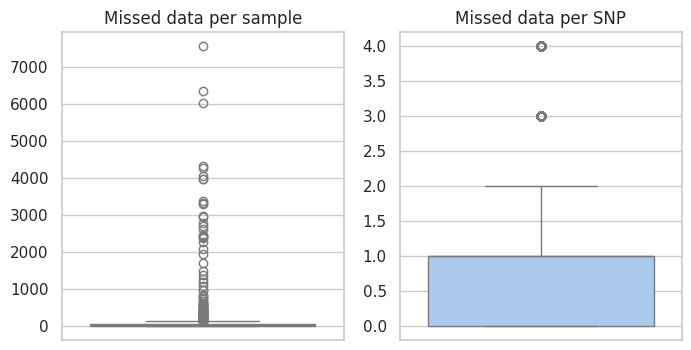

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.boxplot(np.isnan(data).sum(axis=1), ax=axs[0])
sns.boxplot(np.isnan(data).sum(axis=0), ax=axs[1])

axs[0].set_title('Missed data per sample')
axs[1].set_title('Missed data per SNP');

Impute by SNP with mode

In [8]:
# Calculate the mode for each SNP
SNP_mode = sps.mode(data, axis=0, nan_policy='omit').mode[0]

# Impute missing values in each column with the mode
data_imputed = np.where(np.isnan(data), SNP_mode, data)

In [9]:
assert np.isnan(data_imputed).sum()==0, 'You failed'

## Run PCA

Find the best number of components - **Elbow method**

In [ ]:
explained_variance_ratios = []

for k in tqdm(range(1, 31), colour='GREEN'):
    pca = PCA(n_components=k)
    data_transformed = pca.fit_transform(data_imputed)
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum().item()) # .explained_variance_

 70%|███████   | 21/30 [01:02<00:30,  3.38s/it]

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), explained_variance_ratios)
plt.scatter(range(1, 31), explained_variance_ratios)
plt.xlabel('Number of components')
plt.ylabel('Explained ratio');

Very low explained ratio... Okay, run with 10 components, btw we'll plot only 2-3 components

In [ ]:
pca = PCA(n_components=10)
data_transformed = pca.fit_transform(data_imputed)

data_transformed.shape

## Plot main components

In [ ]:
data_pca = pd.DataFrame({'PC1': data_transformed[:, 0],
                         'PC2': data_transformed[:, 1],
                         'PC3': data_transformed[:, 2],
                         'Population': data_pop['Population'].values
                        })

data_pca.sample(5)

In [ ]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Population', 
    data=data_pca,
    s=40,
    edgecolor='k',
    alpha=0.8
)

plt.legend(
    title='Population', title_fontsize='13', fontsize='11', 
    loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, 
    frameon=True, framealpha=0.8
)

plt.xlabel("Principal Component 1", fontsize=14, labelpad=10)
plt.ylabel("Principal Component 2", fontsize=14, labelpad=10)
plt.title("PCA Scatter Plot by Population", fontsize=16, fontweight='bold', pad=15)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke');

In [ ]:
fig = px.scatter_3d(
    data_pca, 
    x='PC1', y='PC2', z='PC3', 
    color='Population',
    title="PCA Ethnicity aggregation",
    opacity=0.8,  
    symbol='Population',
)

fig.update_traces(marker=dict(size=4))

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
    ),
    legend=dict(
        title="Population",
        x=1.05, y=1,
        bgcolor="rgba(255, 255, 255, 0.8)",
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# fig.show()

In [ ]:
fig.write_html(f"{PREFIX}_3d_PCA.html")